In [1]:
!pip install PyDrive

In [2]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 10753 (delta 10), reused 6 (delta 2), pack-reused 10726
Receiving objects: 100% (10753/10753), 11.99 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (7479/7479), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [3]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

import cv2
import time
from torchvision import transforms

from PIL import Image, ImageDraw, ImageFont
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import torch.nn as nn
from skimage import io
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision import utils
from torchvision import datasets, models, transforms
import argparse
import imutils
from imutils.video import VideoStream
import time
from torch.quantization import QuantStub
from torch.utils.tensorboard import SummaryWriter
from engine import train_one_epoch, evaluate

#from QuantStub import apply_quantization

#import detect_utils

#import detect_utils

In [4]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        img_id_num = img_id
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        #path = coco.loadImgs(img_id)[0]['/content/sample_data/my_data']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        boxes = boxes.reshape(-1, 4)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
            #img, my_annotation = self.transforms(img, my_annotation)

        return img, my_annotation,img_id,img_id_num

    def __len__(self):
        return len(self.ids)

In [5]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


In [6]:
# path to your own data and coco file
train_data_dir = '/content/sample_data/my_data'
train_coco = '/content/sample_data/json_data/instances_default.json'


In [7]:
with open(train_coco) as json_file:
    lines = json_file.readlines()
for line in lines:
    print(line)

{"licenses": [{"name": "", "id": 0, "url": ""}], "info": {"contributor": "", "date_created": "", "description": "", "url": "", "version": "", "year": ""}, "categories": [{"id": 1, "name": "Facemask", "supercategory": ""}, {"id": 2, "name": "Face", "supercategory": ""}], "images": [{"id": 1, "width": 1024, "height": 600, "file_name": "pics_9_93.jpg", "license": 0, "flickr_url": "", "coco_url": "", "date_captured": 0}, {"id": 2, "width": 1024, "height": 600, "file_name": "pics_9_91.jpg", "license": 0, "flickr_url": "", "coco_url": "", "date_captured": 0}, {"id": 3, "width": 1024, "height": 600, "file_name": "pics_9_85.jpg", "license": 0, "flickr_url": "", "coco_url": "", "date_captured": 0}, {"id": 4, "width": 1024, "height": 600, "file_name": "pics_9_84.jpg", "license": 0, "flickr_url": "", "coco_url": "", "date_captured": 0}, {"id": 5, "width": 1024, "height": 600, "file_name": "pics_9_8.jpg", "license": 0, "flickr_url": "", "coco_url": "", "date_captured": 0}, {"id": 6, "width": 1024,

In [8]:
import torchvision.datasets as dset
my_dataset = dset.CocoDetection(root = train_data_dir,
                                annFile = train_coco,
                                transforms=get_transform())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [38]:
#img, target-coco_train[0]
#print (img.size)
#(640, 480)

In [8]:
# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1
print('Number of samples: ', len(my_dataset))
my_dataset.root
my_dataset.coco.cats

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of samples:  325


{1: {'id': 1, 'name': 'Facemask', 'supercategory': ''},
 2: {'id': 2, 'name': 'Face', 'supercategory': ''}}

In [9]:
my_dataset[0]

(tensor([[[0.3608, 0.4314, 0.4157,  ..., 0.4941, 0.5020, 0.5216],
          [0.3843, 0.3922, 0.3490,  ..., 0.4941, 0.5059, 0.5216],
          [0.3882, 0.3686, 0.4314,  ..., 0.4941, 0.5059, 0.5216],
          ...,
          [0.4157, 0.4157, 0.4157,  ..., 0.5294, 0.5451, 0.5529],
          [0.4157, 0.4157, 0.4157,  ..., 0.5294, 0.5451, 0.5529],
          [0.4157, 0.4157, 0.4157,  ..., 0.5294, 0.5451, 0.5529]],
 
         [[0.3647, 0.4353, 0.4196,  ..., 0.4784, 0.4863, 0.5059],
          [0.3882, 0.3961, 0.3529,  ..., 0.4784, 0.4902, 0.5059],
          [0.3922, 0.3725, 0.4353,  ..., 0.4784, 0.4902, 0.5059],
          ...,
          [0.4157, 0.4157, 0.4157,  ..., 0.5176, 0.5333, 0.5412],
          [0.4157, 0.4157, 0.4157,  ..., 0.5176, 0.5333, 0.5412],
          [0.4157, 0.4157, 0.4157,  ..., 0.5176, 0.5333, 0.5412]],
 
         [[0.3451, 0.4157, 0.4000,  ..., 0.4353, 0.4431, 0.4627],
          [0.3686, 0.3765, 0.3333,  ..., 0.4353, 0.4471, 0.4627],
          [0.3725, 0.3529, 0.4157,  ...,

In [10]:
# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(my_dataset)).tolist()
train_dataset = torch.utils.data.Subset(my_dataset, indices[:-50])
valid_dataset = torch.utils.data.Subset(my_dataset, indices[-50:])

In [11]:
# # define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

In [12]:
# val DataLoader
data_loader_val = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

In [13]:
len(data_loader_val)

50

In [14]:
len(data_loader_train)

275

In [15]:
# to see few train images with bounding boxes
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

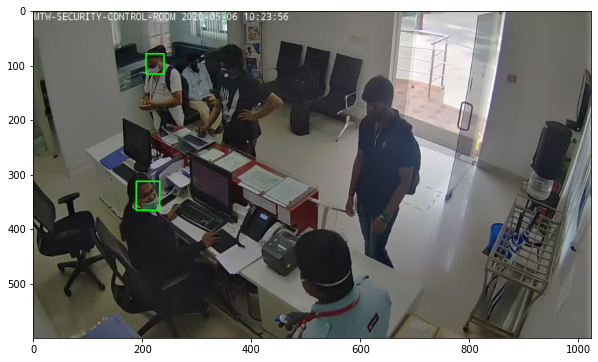

In [16]:
plot_img(train_dataset,230)

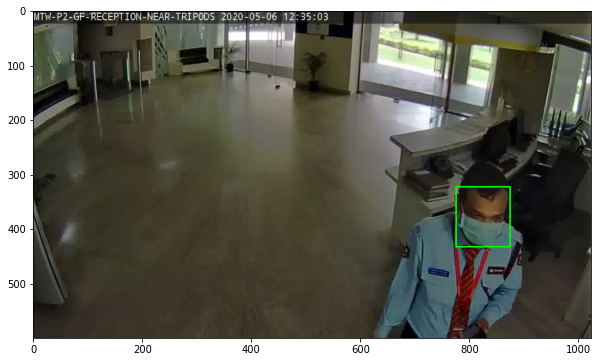

In [17]:
plot_img(valid_dataset,10)

In [18]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
# select device (whether GPU or CPU)
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations,img_id,img_num in data_loader_train:
    #imgs, annotations = next(iter(data_loader_train))
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    

In [20]:
print(annotations)

[{'boxes': tensor([[725.6400, 151.0800, 753.8000, 181.1000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([214], device='cuda:0'), 'area': tensor([845.3632], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]


In [22]:
imgs, annotations,img_id, img_num = next(iter(data_loader_train))

imgs = list(img.to(device) for img in imgs)
annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

In [26]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [21]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# 2 classes; Only target class or background
num_classes = 2
#num_classes = 7
#num_epochs = 2
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
# Load the trained weights


x = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [22]:
print(x)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [23]:

import transforms as T

#import detect_utils
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [24]:
def save_ckp(state, is_best, save_path, filename):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    filename = os.path.join(save_path, filename)
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, filename)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        bestname = os.path.join(save_path, 'model_best.pth.tar')
        shutil.copyfile(filename, bestname)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()


In [27]:
#num_epochs = 20

train_loss_min = 0.1
total_train_loss = []


mpath = '/content/sample_data/chkpoint/'
#best_model_path = '/content/sample_data/bestmodel/'
#best_model_path =  str(epoch) + '_checkpoint.pth.tar'

for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids,img_num in data_loader_train:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
    
#     if lr_scheduler is not None:
#         lr_scheduler.step()
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': epoch_train_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, mpath, str(epoch) + '_checkpoint.pth.tar')
    ## TODO: save the model if validation loss has decreased
    if epoch_train_loss <= train_loss_min:
            print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,epoch_train_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, mpath, str(epoch) + '_checkpoint.pth.tar')
            train_loss_min = epoch_train_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch :1


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch train loss is 0.3328644049082967
0m 57s
Epoch :2
Epoch train loss is 0.26170061756617585
0m 57s
Epoch :3
Epoch train loss is 0.22928759077288718
0m 57s
Epoch :4
Epoch train loss is 0.21500280174193903
0m 57s
Epoch :5
Epoch train loss is 0.19028247486429542
0m 57s
Epoch :6
Epoch train loss is 0.16498164346781613
0m 57s
Epoch :7
Epoch train loss is 0.16743169948686873
0m 57s
Epoch :8
Epoch train loss is 0.15576175247516486
0m 57s
Epoch :9
Epoch train loss is 0.13697293700860014
0m 57s
Epoch :10
Epoch train loss is 0.1356086297476709
0m 57s
Epoch :11
Epoch train loss is 0.1192860322907456
0m 57s
Epoch :12
Epoch train loss is 0.1381493190915419
0m 57s
Epoch :13
Epoch train loss is 0.10888958310528489
0m 57s
Epoch :14
Epoch train loss is 0.10263208590940517
0m 57s
Epoch :15
Epoch train loss is 0.10019976959671609
0m 57s
Epoch :16
Epoch train loss is 0.0916614754786199
Train loss decreased (0.100000 --> 0.091661).  Saving model ...
0m 59s
Epoch :17
Epoch train loss is 0.088402331795914

In [31]:
total_train_loss, total_valid_loss = [], []
epoch_valid_loss, epoch_train_loss = [],[]

global prev_loss
prev_loss = float("inf")
global count
count = 0
mpath = '/content/sample_data/chkpoint/'

In [32]:
# training
def train(epoch):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids,img_num in data_loader_train:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #train_loss/len(train_data_loader.dataset)
        epoch_train_loss = np.mean(train_loss)
        total_train_loss.append(epoch_train_loss)
        print(f'Epoch train loss is {epoch_train_loss}')

In [40]:
# validation
def validation(epoch, flag):
    global prev_loss
    global count
    model.eval()
    valid_loss = 0
    
    for images, targets, image_ids,img_num in data_loader_val:
         #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        valid_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    #train_loss/len(train_data_loader.dataset)
        epoch_valid_loss = np.mean(valid_loss)
        total_valid_loss.append(epoch_valid_loss)
        print(f'Epoch valid loss is {epoch_valid_loss}')
        
        is_best = bool(epoch_valid_loss < prev_loss)
        is_lessequal = bool(epoch_loss >= prev_loss)
    if (is_best):
          prev_loss = epoch_valid_loss
          count = 0
    elif (is_lessequal):
        if (count < 8):
            count = count + 1
        else:
            print("Terminated Training for Early Stopping at Epoch ", epoch+1)
            flag = True

    if flag == False:
#         print(conf_matrix)
        # create checkpoint variable and add important data
        print("m in checkpoint")
        checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': epoch_valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
        #save_checkpoint(checkpoint, is_best, '/content/sample_data/chkpoint/' +epoch+'.pth')
        save_checkpoint(checkpoint, True, mpath, str(epoch) + '_checkpoint.pth.tar')
        #save_ckp(checkpoint, True, mpath, str(epoch) + '_checkpoint.pth.tar')
    return flag
# save_checkpoint
def save_checkpoint(state, is_best, save_path, filename):
    if is_best:
        filename = os.path.join(save_path, filename)
        print("=> Saving a new best")
        torch.save(state, filename)
    else:
        print("=> Validation loss did not reduce")
       

In [41]:
for epoch in range(0, 50):
    flag = False
    train(epoch)
    a = validation(epoch, flag)
    if a == True:
        break

Epoch :1
Epoch train loss is 0.25448665022850037
Epoch train loss is 0.17037548124790192
Epoch train loss is 0.11471665526429813
Epoch train loss is 0.18356723058968782
Epoch train loss is 0.17409136965870858
Epoch train loss is 0.22742540699740252
Epoch train loss is 0.22024144498365267
Epoch train loss is 0.20149709237739444
Epoch train loss is 0.18977189519339138
Epoch train loss is 0.18269026912748815
Epoch train loss is 0.17357101596214555
Epoch train loss is 0.1602900824509561
Epoch train loss is 0.1485659682120268
Epoch train loss is 0.1623648635244795
Epoch train loss is 0.15305745427807171
Epoch train loss is 0.1516453551594168
Epoch train loss is 0.15142651976031415
Epoch train loss is 0.14858801600833735
Epoch train loss is 0.15153205649633156
Epoch train loss is 0.14861087333410977
Epoch train loss is 0.1459401450341656
Epoch train loss is 0.1497192011976784
Epoch train loss is 0.1527790804596051
Epoch train loss is 0.15609764509523907
Epoch train loss is 0.1614271028339862

AttributeError: ignored

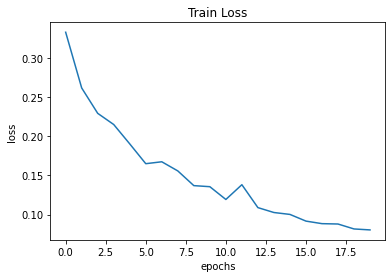

In [28]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.title('valid Loss')
plt.plot(total_valid_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(total_train_loss, label='Training loss')
plt.plot(total_valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [29]:
def process_image(image, model, device = None):
	image_np = np.array(image)

	trs = transforms.Compose([transforms.ToTensor()])
	image = trs(image_np)
	#image = torch.quantize_per_tensor(image, 0.1, 10, torch.quint8)
	# quant = QuantStub()
	# image = quant(image)

	if device is not None:
		image = image.to(device)
		print("Here")

	with torch.no_grad():
		output = model([image])[0]
		print(output)


	boxes = output["boxes"].cpu().numpy().tolist()
	scores = output["scores"].cpu().numpy().tolist()
	labels = output["labels"].cpu().numpy().tolist()


	class_to_label = {
		2: "Face", 
		1: "Facemask"
	}
	
	for idx, box in enumerate(boxes):
		if scores[idx] >= THRESHOLD:
			print(box)
			label = class_to_label[labels[idx]]
			color = (0, 255, 0) if label == "Facemask" else (0, 0, 255)
			cv2.putText(image_np, label, (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 2)
			cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)

	return image_np


Here
{'boxes': tensor([[140.2365, 185.0224, 169.4817, 222.4858],
        [142.4943, 202.6744, 169.3700, 222.9265],
        [249.6879, 350.6367, 269.9833, 385.2776],
        [241.1180, 340.2758, 272.5112, 392.5913],
        [152.4975, 187.8698, 172.5183, 221.9758],
        [136.5677, 178.9601, 173.5437, 240.9039],
        [133.5337, 189.7000, 175.4001, 213.5073],
        [123.6068, 186.8883, 194.2893, 221.5004]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9788, 0.2643, 0.2416, 0.1185, 0.0711, 0.0686, 0.0518, 0.0508],
       device='cuda:0')}
[140.2364501953125, 185.02236938476562, 169.48167419433594, 222.4857940673828]


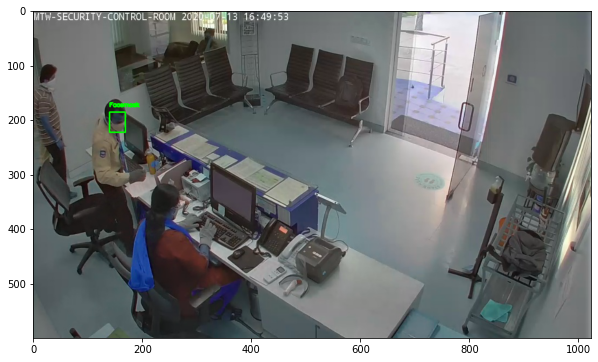

In [34]:
model.eval()
#model = apply_quantization(model)
#model.load_state_dict(torch.load("quantized_model.pt"))

THRESHOLD = 0.5
img_path = '/content/sample_data/test/25.jpg'
image = Image.open(img_path).convert("RGB")
processed_image = process_image(image, model, device)
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(processed_image)
#cv2.imshow("Output", processed_image)
#cv2.waitKey(0)

Here
{'boxes': tensor([[337.5323,  62.7005, 355.8679,  87.3178]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9694], device='cuda:0')}
[337.53228759765625, 62.70048141479492, 355.8678894042969, 87.31778717041016]


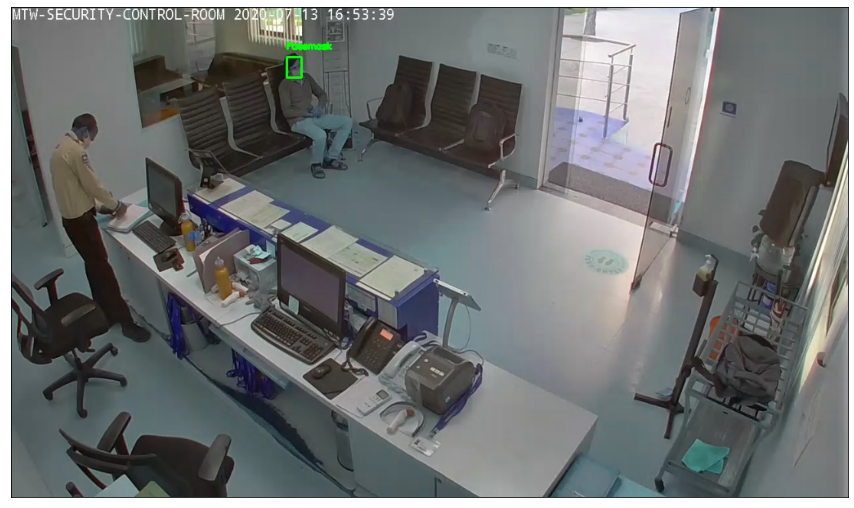

In [30]:
model.eval()
#model = apply_quantization(model)
#model.load_state_dict(torch.load("quantized_model.pt"))

THRESHOLD = 0.5
img_path = '/content/sample_data/test/29.jpg'
image = Image.open(img_path).convert("RGB")
processed_image = process_image(image, model, device)
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15)) # display the output image
plt.imshow(processed_image)
plt.xticks([])
plt.yticks([])
plt.show()

#cv2.imshow("Output", processed_image)
#cv2.waitKey(0)

Here
{'boxes': tensor([[ 58.2418, 277.8347,  88.6677, 329.0338],
        [571.9632, 105.6502, 597.0263, 137.1424]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.9793], device='cuda:0')}
[58.241817474365234, 277.83465576171875, 88.66765594482422, 329.03375244140625]
[571.9631958007812, 105.65015411376953, 597.0263061523438, 137.14244079589844]


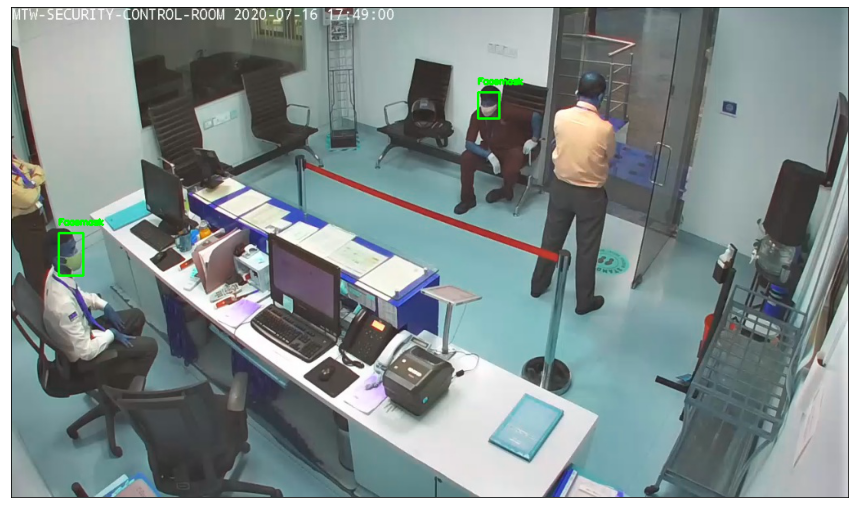

In [31]:
THRESHOLD = 0.5
img_path = '/content/sample_data/test/40.jpg'
image = Image.open(img_path).convert("RGB")
processed_image = process_image(image, model, device)
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15)) # display the output image
plt.imshow(processed_image)
plt.xticks([])
plt.yticks([])
plt.show()

Here
{'boxes': tensor([[ 12.3759, 287.6576,  51.3886, 342.0212],
        [571.0428, 102.1306, 596.9780, 134.6033]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9861, 0.9817], device='cuda:0')}
[12.375887870788574, 287.6575622558594, 51.388633728027344, 342.02117919921875]
[571.0427856445312, 102.130615234375, 596.97802734375, 134.603271484375]


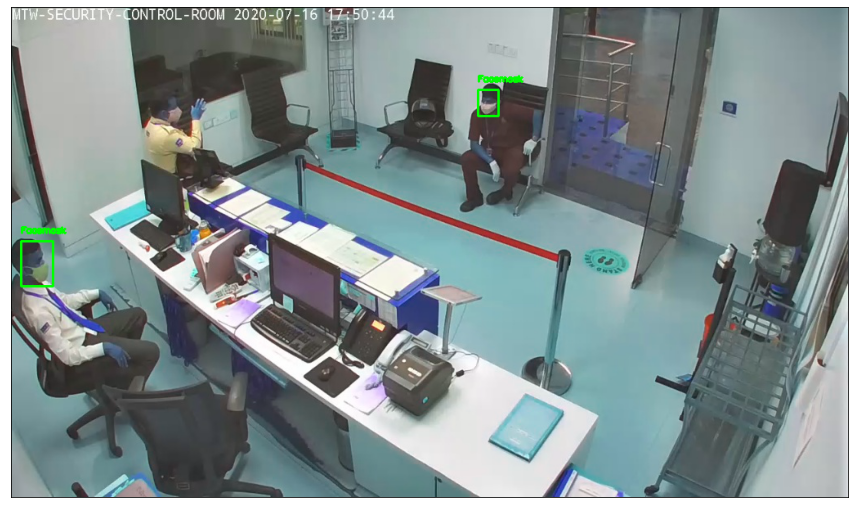

In [32]:
THRESHOLD = 0.5
img_path = '/content/sample_data/test/49.jpg'
image = Image.open(img_path).convert("RGB")
processed_image = process_image(image, model, device)
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15)) # display the output image
plt.imshow(processed_image)
plt.xticks([])
plt.yticks([])
plt.show()

Here
{'boxes': tensor([[736.3466,   4.4237, 756.0917,  26.9381],
        [343.6328,  63.1706, 363.4434,  86.4321]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8884, 0.7282], device='cuda:0')}
[736.3466186523438, 4.423709392547607, 756.0916748046875, 26.9381103515625]
[343.6327819824219, 63.170623779296875, 363.44342041015625, 86.43214416503906]


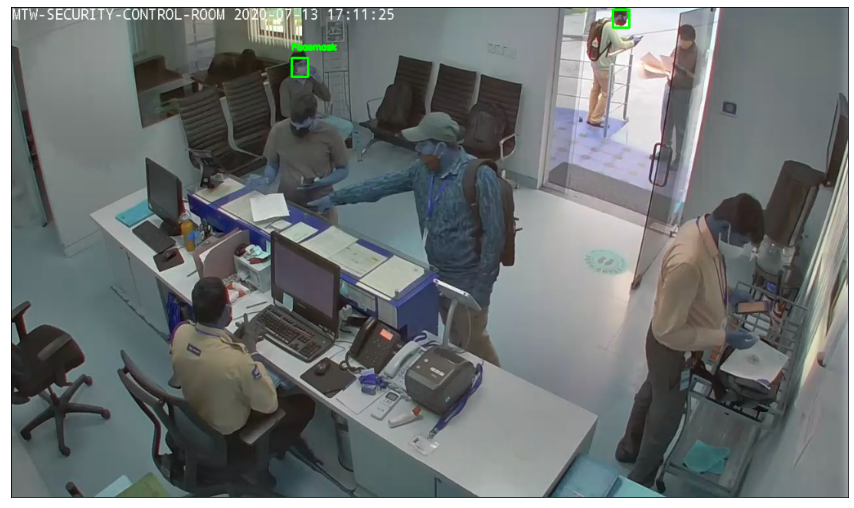

In [33]:
THRESHOLD = 0.5
img_path = '/content/sample_data/test/33.jpg'
image = Image.open(img_path).convert("RGB")
processed_image = process_image(image, model, device)
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15)) # display the output image
plt.imshow(processed_image)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
image = Image.open('/content/sample_data/test/25.jpg')
model.eval().to(device)
boxes, classes, labels = detect_utils.predict(image, model, device, 0.8)
image = detect_utils.draw_boxes(boxes, classes, labels, image)
cv2.imshow('Image', image)

In [ ]:
loss_hist = Averager()
itr = 1
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for imgs, annotations,image_ids in data_loader_train:
        
        imgs = list(image.to(device) for image in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        loss_dict = model(imgs, annotations)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    # evaluate on the test dataset
    #evaluate(model, data_loader_val, device=device)

In [ ]:
# let's train it for 10 epochs

#num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)

In [46]:
#from PIL import Image
#Image.open('/content/sample_data/test-data/25.jpg')

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [38]:
img_path = '/content/sample_data/testdata/images_5_57.jpg'

In [42]:
def get_prediction(img_path, threshold):

  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img ,target) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class


In [43]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):

  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(20,30)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [ ]:
img_path = '/media/ssd/ssd data/VOC2007/JPEGImages/000001.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200).show()  

In [ ]:
itr = 1
total_train_loss = []
        
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = []
   # model.train()
   
    for imgs, annotations in data_loader_valid:
      #  i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        #Forward propagation
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        #Reseting Gradients
        optimizer.zero_grad()
        #backward propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        itr += 1

        print(f'Iteration: {i}/{len_dataloader_valid}, Loss: {losses}')
        epoch_valid_loss = np.mean(valid_loss)
        total_valid_loss.append(epoch_valid_loss)
        print(f'Epoch train loss is {epoch_valid_loss:.4f}')
        time_elapsed = time.time() - start_time
        print("Time elapsed: ",time_elapsed)
        